

```
# Setup
```

In [ ]:
!nvidia-smi # runtime T4 GPU ашиглана

# --- Гол libraries суулгах
!pip -q install -U "transformers[torch]" datasets accelerate peft sentencepiece evaluate rouge_score bitsandbytes wandb

# --- Import test хийх, version -г хэвлэх
import torch, transformers, datasets, peft, evaluate
print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("PEFT:", peft.__version__)



Sun Nov  2 13:36:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# --- Hugginface -руу нэтврэх
from huggingface_hub import login
login()

In [ ]:
from transformers import AutoTokenizer

model_name = "amaraaa/mt5-base-summarization-mn-v1"

tokenizer = AutoTokenizer.from_pretrained(model_name)

mongolian_text = "Багш нарын цалин хөлсийг нэмэгдүүлэх шаардлагыг тус холбооноос тавьж, улмаар Боловсролын яамныхантай хэлцэлд ч орсон. Боловсролын сайд П.Наранбаяр “Багш нарын үндсэн цалинг 3.5 сая төгрөг болгон нэмэгдүүлэхэд 3.3 их наяд төгрөг шаардлагатай. Энэ эх үүсвэрийг ирэх онд гаргах боломжгүй. Үе шаттай багш нарын цалинг нэмэх боломж бий” гэж мэдэгдээд байгаа."

inputs = tokenizer(mongolian_text, return_tensors="pt", max_length=768, truncation=True, padding=True)

# print(f"Token id: {inputs['input_ids']}")
print(f"Нийт токен: {len(inputs['input_ids'][0])}")

Нийт токен: 133


# preprocess хийхийн өмнө schema -г бататгах
Load & inspect dataset

In [ ]:
from datasets import load_dataset

# 1) Load all splits
ds = load_dataset("amaraaa/mn_translated_cnn_extended")
print(ds)

# 2) Train split -ээс хэдэн мөрүүдийг шалгая
for i in range(2):
  row = ds["train"][i]
  print(f"nRow {i} keys:", row.keys())
  print("id:", row["id"])
  print("article snippet:", (row["article"] or "")[:200].replace("\n"," "))
  print("highlights (type/len):", type(row["highlights"]).__name__, len(row["highlights"]))
  print("first highlight:", row["highlights"][0] if row["highlights"] else "-")

# 3) Sanity checks - Алдаанаас сэргийлж шалгалт хийх (data sanity checks)
def summarize_split(name):
  d = ds[name]
  # Хоосон article байгаа эсэхийг шалгах
  empty_articles = sum(1 for r in d if not r["article"] or not r["article"].strip())
  # Хоосон highlights байгаа эсэхийг шалгах
  empty_highlights = sum(1 for r in d if not r["highlights"] or not r["highlights".strip()])
  return {
      "rows": len(d),
      "empty_articles": empty_articles,
      "empty_highlights": empty_highlights,
  }

print("\nSanity:")
for split in ds.keys():
  print(split, summarize_split(split))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/559 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/7.08M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/380k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/367k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1862 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/106 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/95 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 1862
    })
    validation: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 106
    })
    test: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 95
    })
})
nRow 0 keys: dict_keys(['id', 'article', 'highlights'])
id: 0000800d9058217f6509d7e63ad475e2de0da611
article snippet: . Ричард Спиллетт. Машинд цэнэглэж байх үед дэлбэрсэн электрон тамхи нь бүтээгдэхүүний аюулгүй байдлын талаар шинэ айдас төрүүлэв. 54 настай асран хамгаалагч Ким Тейлор машинаас гал болон өтгөн хар ут
highlights (type/len): list 5
first highlight: 54 настай Ким Тейлор төхөөрөмжөө Ford Mondeo машины арын суудалд залгаад орхижээ.
nRow 1 keys: dict_keys(['id', 'article', 'highlights'])
id: 0000bf554ca24b0c72178403b54c0cca62d9faf8
article snippet: . Алекс Уорд. Баян хөрөнгө оруулагчдаас олон сая фунт стерлинг залилсан хотын худалдаачин өчигдөр нэг фунт сте

# Build preprocessing - (model training -д зориулж өгөгдлийг бэлдэх)
* mT5 нь single target string хүлээж авдаг
* highlights -д мөр бүрт string list байгаа

1) Иймээс list -ийн агуулгыг newline -тай нэг text болгоно
2) inputs/targets -ийг tokenize хийнэ (consistent max lengths)

In [ ]:
from datasets import DatasetDict
from transformers import AutoTokenizer

# --- Тохируулга хийх
model_name = "google/mt5-base"
task_prefix = "summarize: " # t5 model -д ямар таск хийхийг prefix зааж өгнө
max_source_length = 768
max_target_length = 128

# 1) Highlight -уудын list -ийг single string болгож join хийх
def join_highlights(example): # (example -> single record)
  bullets = example.get("highlights") or []
  # keep only non-empty strings and strip whitespace
  bullets = [str(x).strip() for x in bullets if isinstance(x, str) and str(x).strip()]
  example["highlights_str"] = "\n".join(bullets)
  # print(example)
  return example

# Функцийг split бүрийн record дээр ажилуулна
ds = ds.map(join_highlights, desc="Joining highlight bullets")

# 2) Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 3) Tokenize inputs & targets - (article, highlights)
def preprocess_batch(batch):
  # input text + task hint
  inputs = [task_prefix + (article or "") for article in batch["article"]]
  targets = batch["highlights_str"]

  # tokenize sources
  model_inputs = tokenizer(
      inputs,
      max_length=max_source_length,
      truncation=True,
  )

  # tokenize targets (labels)
  labels = tokenizer(
      text_target=targets,
      max_length=max_target_length,
      truncation=True,
  )

  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

# cols_to_remove = list(set(ds["train"].column_names) - {"id"})
# Remove original columns and the joined highlights string, including 'id'
cols_to_remove = ["id", "article", "highlights", "highlights_str"]

tokenized_ds = ds.map(
    preprocess_batch,
    batched=True,
    remove_columns=cols_to_remove,
    desc="Tokenizing"
)

print(tokenized_ds)
print("Example ids:", tokenized_ds["train"][0]["input_ids"][:20], "...")
print("Example labels:", tokenized_ds["train"][0]["labels"][:20], "...")

# --- Tokenized хослолыг шалгах
sample = tokenized_ds["train"][0]
print(tokenizer.decode(sample["input_ids"][:128], skip_special_tokens=True))

# Safe label preview: (replace -100 with pad id before decoding)
safe_labels = [(tid if tid != -100 else tokenizer.pad_token_id) for tid in sample["labels"]]
print(tokenizer.decode(safe_labels[:64], skip_special_tokens=True))



Joining highlight bullets:   0%|          | 0/1862 [00:00<?, ? examples/s]

Joining highlight bullets:   0%|          | 0/106 [00:00<?, ? examples/s]

Joining highlight bullets:   0%|          | 0/95 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Tokenizing:   0%|          | 0/1862 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/106 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/95 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1862
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 106
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 95
    })
})
Example ids: [196098, 10701, 267, 259, 260, 1936, 176023, 902, 688, 94817, 237497, 260, 259, 96430, 902, 259, 68991, 129424, 990, 17157] ...
Example labels: [7013, 310, 85482, 1035, 1104, 1454, 1011, 104221, 16661, 605, 72599, 17159, 31915, 10241, 61397, 268, 259, 50835, 259, 20903] ...
summarize: . Ричард Спиллетт. Машинд цэнэглэж байх үед дэлбэрсэн электрон тамхи нь бүтээгдэхүүний аюулгүй байдлын талаар шинэ айдас төрүүлэв. 54 настай асран хамгаалагч Ким Тейлор машинаас гал болон өтгөн хар утаа гарч байгааг анзаарахаасаа өмнө аравхан минутын турш төхөөрөмжийг цэнэглэж орхижээ. Тухайн үед дотор нь хэн ч байгаагүй ч арын суудал бүрэн 
54 

# Load mT5-small & attach LoRa adapters
LoRa гэх мэт PEFT method -оор model сургахдаа бэлдэх (peft configuration)

LoRa -> суурь model -ийг бүхэлд нь биш зөвхөн тодорхой цөөн weight -үүдийг сургана.
*   Resrource бага шаардана
*   Илүү efficient байх боломжтой
*   Model -ийн цөөн тооны parameter -ийг үр дүнтэй fine-tune хийнэ.
*   Computational болон storage cost багасгана.


In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM
from peft import LoraConfig, get_peft_model, TaskType

#1) Load base model
base_model_name = "google/mt5-base"
model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name)

# Move the model to the GPU
model.to("cuda")
print(next(model.parameters()).device)

# --- after loading tokenizer/model ---
# For T5-family, set these explicitly:
model.config.decoder_start_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id

#2) (recommended for memory) - enable gradient checkpointing later during training
model.config.use_cache = False
# model.config.decoder_start_token_id = tokenizer.pad_token_id

#3) LoRa config тохируулах
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM, #LoRA-г seq2seq төрлийн хэлний model дээр ашиглана гэж зааж өгнө
    r=8, # нэмэлтээр сургах жижгэрүүлсэн матрицын хэмжээ
    lora_alpha=16, # LoRA -гаар сурсан өөрчлөлтөд хэдий хэмжээний weight өгөх вэ гэдгийг зааж өгнө
    lora_dropout=0.1, # overfitting үүсэхээс сэргийлнэ. Model -ийн хэт өөртөө итгэлтэй байдлыг бууруулахад хэрэгтэй
    target_modules=["q", "k" ,"v", "o"], # self-attention давхаргын гол жингүүд дээр LoRA -г оруулна
    bias="none", # LoRA нэмэх үед шинэ bias нэмэхгүй. Санах ой, параметрийн тоог нэмж өсгөхгүй
)

#4) Model -д LoRa technique -ийг apply хийнэ
model = get_peft_model(model, peft_config)

# Enable input gradients for gradient checkpointing
model.enable_input_require_grads()

#5) Хэчнээн params сургахаа харах
model.print_trainable_parameters()

pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

cuda:0
trainable params: 1,769,472 || all params: 584,170,752 || trainable%: 0.3029


In [ ]:
# 2) Sentinel blocklist үүсгэх (T5 extra_id 0..99) -> for generation
vsize = tokenizer.vocab_size
extra_ids = list(range(vsize - 100, vsize))
bad_words_ids = [[i] for i in extra_ids]
print(f"Blocking {len(bad_words_ids)} sentinel IDs: {extra_ids[0]}..{extra_ids[-1]}")

# After building bad_words_ids
model.generation_config.bad_words_ids = bad_words_ids

Blocking 100 sentinel IDs: 250000..250099


# Trainer тохируулга (metrics, collator, hyperparams)
Rouge metrics, batching/padding, hyperparameters тохируулах


In [ ]:
import numpy as np
import evaluate
from transformers import(
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    EarlyStoppingCallback,
)

#1) Metric: ROUGE
rouge = evaluate.load("rouge")

def postprocess_text(preds, labels):
  # strip хийгээд sentence хоороod newline нэмэх
  preds = [p.strip() for p in preds]
  labels = [l.strip() for l in labels]
  return preds, labels

def compute_metrics(eval_pred):
  preds, labels = eval_pred

  # Some trainers return (sequences)
  if isinstance(preds, tuple):
      preds = preds[0] #take token IDs matrix

  # IMPORTANT: decode хийхээс өмнө ignore index (-100) -г real pad token ID -аар солих
  #preds
  if isinstance(preds, np.ndarray):
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
  else:
    # fallback in case preds is a list
    preds = [[(tok if tok != -100 else tokenizer.pad_token_id) for tok in seq] for seq in preds]
  #labels
  if isinstance(labels, np.ndarray):
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  else:
    # fallback in case labels is a list
    labels = [[(tok if tok != -100 else tokenizer.pad_token_id) for tok in seq] for seq in labels]

  # print("Debugging: (computer_metrics) ")
  # print("Type of preds:", type(preds))
  # print("Preds -> first 50 values", preds[:50])
  # print("Type of labels:", type(labels))
  # print("Labels -> first 50 values", labels[:50])
  # print("---------------------------------")

  # decode predictions
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  # print(decoded_preds) # Debugging line, uncomment if needed

  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # light cleanup for ROUGE
  decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

  # Compute ROUGE
  result = rouge.compute(
      predictions=decoded_preds,
      references=decoded_labels,
      use_stemmer=True,
  )

  # # add a smiple generation length metric
  # gen_lens = [np.count_nonzero(p != tokenizer.pad_token_id) for p in preds]
  # result["gen_len"] = float(np.mean(gen_lens))
  # # focus metric alias
  # result["rougeLsum"] = result.get("rougeLsum", result.get("rougeL", 0.0))
  # return {k: round(v * 100, 4) if k.startswith("rouge") else round(v, 2) for k, v in result.items()}

  return {k: round(v * 100, 4) for k, v in result.items()}

#2) dynamic padding & label masking (-100)
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    label_pad_token_id=-100,
    pad_to_multiple_of=8 if torch.cuda.is_available() else None,
)

#3) Enable memory savers
model.gradient_checkpointing_enable() #

#4) Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="mt5_mncnn_lora",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_rougeLsum",
    greater_is_better=True,
    save_total_limit=2,
    predict_with_generate=True,
    generation_max_length=128,
    generation_num_beams=4, #давтамжийг багасгана, үр дүнг сайжруулна.
    per_device_train_batch_size=16, #GPU дээр нэг удаад хэр их sample process хийхийг тодорхойлно
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    num_train_epochs=10,
    optim="adafactor",
    learning_rate=1e-3, #LoRa -д тохиромжтой learning rate
    warmup_ratio=0.08, #сургалтын явцад learning rate -ийг ихэсгэнэ
    weight_decay=0.0,
    lr_scheduler_type="constant_with_warmup",
    label_smoothing_factor=0.1,
    fp16=False, #on T4
    max_grad_norm=1.0,
    logging_steps=25,
    report_to="none",
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    group_by_length=True,
    seed=42,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# training_args = training_args.replace(lr_scheduler_type="cosine", warmup_ratio=0.1

# Add early stopping (prevents overfitting on 369 rows)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3))

print("Ready to train.")
print("Train rows:", len(tokenized_ds["train"]), "| Val rows:", len(tokenized_ds["validation"]))

Ready to train.
Train rows: 1862 | Val rows: 106


/tmp/ipython-input-3024364008.py:121: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


# Sanity check before full training

In [ ]:
# Small slice of eval to test metrics & decoding path
small_eval = tokenized_ds["validation"].select(range(20))
eval_result = trainer.evaluate(eval_dataset=small_eval)

print(eval_result)


{'eval_loss': 9.557144165039062, 'eval_model_preparation_time': 0.0277, 'eval_rouge1': 0.0, 'eval_rouge2': 0.0, 'eval_rougeL': 0.0, 'eval_rougeLsum': 0.0, 'eval_runtime': 21.674, 'eval_samples_per_second': 0.923, 'eval_steps_per_second': 0.092}


# Training эхлүүлэх - (LoRa on mT5-small)

In [ ]:
# # ──────────────────────────────────────────────────────────────
# # 8) Evaluate → Train → Evaluate
# # ──────────────────────────────────────────────────────────────
# print("Eval (before training):")
# metrics_before = trainer.evaluate()
# print(metrics_before)

# Training
train_result = trainer.train()

# Save the best checkpoint (load_best_model_at_the_end=True)
trainer.save_model("mt5_mncnn_lora/best") # saves LoRa adapter weights + config
tokenizer.save_pretrained("mt5_mncnn_lora/best")

# see a short summary of training
print(train_result)

# Eval after training
print("Eval (before training):")
metrics_after = trainer.evaluate()
print(metrics_after)

Epoch,Training Loss,Validation Loss,Model Preparation Time,Rouge1,Rouge2,Rougel,Rougelsum
1,7.799700,4.157093,0.027700,10.209400,2.785300,10.197600,10.251000
2,4.660500,3.965632,0.027700,11.259900,4.202900,10.884700,10.969800
3,4.433600,3.870983,0.027700,13.781600,2.725600,13.632200,13.846800
4,4.362800,3.763437,0.027700,12.934800,3.599100,12.917000,12.658700
5,4.304500,3.739943,0.027700,13.747100,3.780500,13.992900,13.869700
6,4.262500,3.752592,0.027700,14.694900,4.591200,14.329500,14.529200
7,4.238300,3.689864,0.027700,16.056700,4.681200,15.792300,15.834300
8,4.176000,3.675377,0.027700,18.706300,5.360400,18.458800,18.762500
9,4.168000,3.672672,0.027700,13.120100,5.012600,13.068300,13.088900
10,4.127700,3.656408,0.027700,15.382600,4.157200,15.268700,15.407400


TrainOutput(global_step=590, training_loss=4.904816546682584, metrics={'train_runtime': 7332.9491, 'train_samples_per_second': 2.539, 'train_steps_per_second': 0.08, 'total_flos': 3.2911791754346496e+16, 'train_loss': 4.904816546682584, 'epoch': 10.0})


In [ ]:
# Сургасан model -оо хадгалах

#1) Google Drive -руу хадгалах
SAVE_DIR = "/content/drive/MyDrive/mt5_base_finetuned_v1"

from google.colab import drive
drive.mount('/content/drive')

trainer.save_model(SAVE_DIR) # with PEFT: saves LoRA adapter + peft_config.json
tokenizer.save_pretrained(SAVE_DIR) # tokenizer files
model.config.save_pretrained(SAVE_DIR)
print("Saved to:", SAVE_DIR)


Mounted at /content/drive
Saved to: /content/drive/MyDrive/mt5_base_finetuned_v1


# Merge LoRA → base weights locally and self-test

In [ ]:
from peft import PeftConfig
from pathlib import Path

ADAPTER_DIR = "mt5_mncnn_lora/best"     # <-- change if yours is different
MERGED_DIR  = "mt5_mncnn_merged"

peft_cfg = PeftConfig.from_pretrained(ADAPTER_DIR)
BASE_ID = peft_cfg.base_model_name_or_path
print("Base model recorded in adapter:", BASE_ID)
Path(MERGED_DIR).mkdir(parents=True, exist_ok=True)

Base model recorded in adapter: google/mt5-base


# Load base, attach adapter, merge and unload

In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from peft import PeftModel

def pick_dtype():
    if torch.cuda.is_available():
        major, _ = torch.cuda.get_device_capability(0)
        return torch.bfloat16 if major >= 8 else torch.float16  # bf16 on Ampere+; else fp16
    return torch.float32

dtype = pick_dtype()

base = AutoModelForSeq2SeqLM.from_pretrained(BASE_ID, torch_dtype=dtype)
tok  = AutoTokenizer.from_pretrained(ADAPTER_DIR)  # prefer your saved tokenizer
model = PeftModel.from_pretrained(base, ADAPTER_DIR)

# The key step:
merged = model.merge_and_unload()   # applies LoRA deltas into base weights in-place
merged.eval()

`torch_dtype` is deprecated! Use `dtype` instead!


MT5ForConditionalGeneration(
  (shared): Embedding(250112, 768)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 768)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
         

# Save merged model (+ tokenizer + generation config)

In [ ]:
# Save weights/config
merged.save_pretrained(MERGED_DIR)

# Tokenizer
tok.save_pretrained(MERGED_DIR)

# Generation config (if present on the current model)
try:
    merged.generation_config.save_pretrained(MERGED_DIR)
    print("Saved generation_config.json")
except Exception as e:
    print("No generation_config to save:", e)

Saved generation_config.json


In [ ]:
import os, glob
MERGED_DIR = "mt5_mncnn_merged"  # or whatever you used above
print("cwd:", os.getcwd())
print("exists:", os.path.isdir(MERGED_DIR))
print("contents (first 20):")
for p in sorted(glob.glob(f"{MERGED_DIR}/**/*", recursive=True))[:20]:
    print(" ", p)


cwd: /content
exists: True
contents (first 20):
  mt5_mncnn_merged/config.json
  mt5_mncnn_merged/generation_config.json
  mt5_mncnn_merged/model.safetensors
  mt5_mncnn_merged/special_tokens_map.json
  mt5_mncnn_merged/spiece.model
  mt5_mncnn_merged/tokenizer.json
  mt5_mncnn_merged/tokenizer_config.json


In [ ]:
# Either CLI (in a notebook cell)
# !huggingface-cli login

# Or Python:
from huggingface_hub import login
login()  # paste your HF token from https://huggingface.co/settings/tokens

In [ ]:
from huggingface_hub import upload_folder

repo_id = "amaraaa/mt5-base-summarization-mn-v1"
upload_folder(
    repo_id=repo_id,
    folder_path=MERGED_DIR,
    commit_message="Add merged mT5 Mongolian summarization model",
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...mncnn_merged/spiece.model: 100%|##########| 4.31MB / 4.31MB            

  ...cnn_merged/tokenizer.json:   3%|3         |  529kB / 16.3MB            

  ..._merged/model.safetensors:   3%|3         | 41.2MB / 1.24GB            

CommitInfo(commit_url='https://huggingface.co/amaraaa/mt5-base-summarization-mn-v1/commit/372b59e47b5e8ada06253d8e9d8a9dbafaebe47c', commit_message='Add merged mT5 Mongolian summarization model', commit_description='', oid='372b59e47b5e8ada06253d8e9d8a9dbafaebe47c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/amaraaa/mt5-base-summarization-mn-v1', endpoint='https://huggingface.co', repo_type='model', repo_id='amaraaa/mt5-base-summarization-mn-v1'), pr_revision=None, pr_num=None)

# График харуулах (loss, epoch)

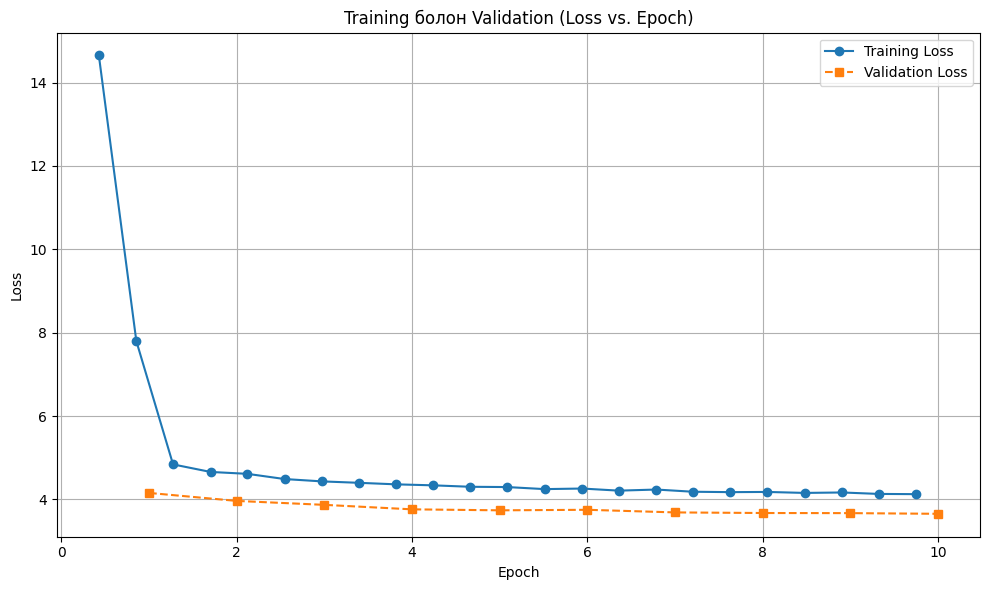

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# fine-tuning дууссаны дараа
def plot_training_loss(trainer):
    """
    Trainer object -ийн history -гоос (training loss/ validation loss) -ийг авах
    """
    # Extract the log history from the trainer state
    history = trainer.state.log_history

    # Convert history list to a pandas DataFrame for easier manipulation
    df = pd.DataFrame(history)

    # Filter for training loss entries
    # The key names might vary slightly ('loss', 'train_loss', 'eval_loss', etc.)
    train_loss_df = df.dropna(subset=['loss'])

    # Filter for validation loss entries
    eval_loss_df = df.dropna(subset=['eval_loss'])

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot training loss
    if not train_loss_df.empty:
        plt.plot(train_loss_df['epoch'], train_loss_df['loss'], label='Training Loss', marker='o', linestyle='-')

    # Plot validation loss
    if not eval_loss_df.empty:
        # We need to map evaluation steps to the correct epoch values
        plt.plot(eval_loss_df['epoch'], eval_loss_df['eval_loss'], label='Validation Loss', marker='s', linestyle='--')

    plt.title('Training болон Validation (Loss vs. Epoch)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- How to use it ---
# After you run your trainer.train() command, call the function:

# Example usage (commented out as the trainer object is not defined here):
plot_training_loss(trainer)


# Graph

In [1]:
!pip -q install -U datasets sentencepiece evaluate rouge_score

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_id = "amaraaa/mt5-base-summarization-mn-v1"  # e.g. "amaraaa/mt5-base-summarization-mn-v1"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
model.eval()


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 12.3 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/416 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/783 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 768)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 768)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
         

In [2]:
from datasets import load_dataset

dataset_id = "amaraaa/mn_translated_cnn_extended"  # e.g. "amaraaa/mn_translated_cnn_extended"
ds = load_dataset(dataset_id)

# test_dataset_raw = raw_datasets["test"]


README.md:   0%|          | 0.00/606 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/7.08M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/380k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/367k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1862 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/106 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/95 [00:00<?, ? examples/s]

In [3]:
# 2) Sentinel blocklist үүсгэх (T5 extra_id 0..99) -> for generation
vsize = tokenizer.vocab_size
extra_ids = list(range(vsize - 100, vsize))
bad_words_ids = [[i] for i in extra_ids]
print(f"Blocking {len(bad_words_ids)} sentinel IDs: {extra_ids[0]}..{extra_ids[-1]}")

# After building bad_words_ids
model.config.decoder_start_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.generation_config.bad_words_ids = bad_words_ids

Blocking 100 sentinel IDs: 250000..250099


In [4]:
from datasets import DatasetDict
from transformers import AutoTokenizer

# --- Тохируулга хийх
task_prefix = "summarize: " # t5 model -д ямар таск хийхийг prefix зааж өгнө
max_source_length = 768
max_target_length = 128

# 1) Highlight -уудын list -ийг single string болгож join хийх
def join_highlights(example): # (example -> single record)
  bullets = example.get("highlights") or []
  # keep only non-empty strings and strip whitespace
  bullets = [str(x).strip() for x in bullets if isinstance(x, str) and str(x).strip()]
  example["highlights_str"] = "\n".join(bullets)
  # print(example)
  return example

# Функцийг split бүрийн record дээр ажилуулна
ds = ds.map(join_highlights, desc="Joining highlight bullets")

# 3) Tokenize inputs & targets - (article, highlights)
def preprocess_batch(batch):
  # input text + task hint
  inputs = [task_prefix + (article or "") for article in batch["article"]]
  targets = batch["highlights_str"]

  # tokenize sources
  model_inputs = tokenizer(
      inputs,
      max_length=max_source_length,
      truncation=True,
  )

  # tokenize targets (labels)
  labels = tokenizer(
      text_target=targets,
      max_length=max_target_length,
      truncation=True,
  )

  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

# cols_to_remove = list(set(ds["train"].column_names) - {"id"})
# Remove original columns and the joined highlights string, including 'id'
cols_to_remove = ["id", "article", "highlights", "highlights_str"]

tokenized_ds = ds.map(
    preprocess_batch,
    batched=True,
    remove_columns=cols_to_remove,
    desc="Tokenizing"
)

print(tokenized_ds)
print("Example ids:", tokenized_ds["train"][0]["input_ids"][:20], "...")
print("Example labels:", tokenized_ds["train"][0]["labels"][:20], "...")

# --- Tokenized хослолыг шалгах
sample = tokenized_ds["train"][0]
print(tokenizer.decode(sample["input_ids"][:128], skip_special_tokens=True))

# Safe label preview: (replace -100 with pad id before decoding)
safe_labels = [(tid if tid != -100 else tokenizer.pad_token_id) for tid in sample["labels"]]
print(tokenizer.decode(safe_labels[:64], skip_special_tokens=True))



Joining highlight bullets:   0%|          | 0/1862 [00:00<?, ? examples/s]

Joining highlight bullets:   0%|          | 0/106 [00:00<?, ? examples/s]

Joining highlight bullets:   0%|          | 0/95 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/1862 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/106 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/95 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1862
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 106
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 95
    })
})
Example ids: [196098, 10701, 267, 259, 260, 1936, 176023, 902, 688, 94817, 237497, 260, 259, 96430, 902, 259, 68991, 129424, 990, 17157] ...
Example labels: [7013, 310, 85482, 1035, 1104, 1454, 1011, 104221, 16661, 605, 72599, 17159, 31915, 10241, 61397, 268, 259, 50835, 259, 20903] ...
summarize: . Ричард Спиллетт. Машинд цэнэглэж байх үед дэлбэрсэн электрон тамхи нь бүтээгдэхүүний аюулгүй байдлын талаар шинэ айдас төрүүлэв. 54 настай асран хамгаалагч Ким Тейлор машинаас гал болон өтгөн хар утаа гарч байгааг анзаарахаасаа өмнө аравхан минутын турш төхөөрөмжийг цэнэглэж орхижээ. Тухайн үед дотор нь хэн ч байгаагүй ч арын суудал бүрэн 
54 

In [5]:
import numpy as np
import evaluate
from transformers import(
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    EarlyStoppingCallback,
)

#1) Metric: ROUGE
rouge = evaluate.load("rouge")

def postprocess_text(preds, labels):
  # strip хийгээд sentence хоороod newline нэмэх
  preds = [p.strip() for p in preds]
  labels = [l.strip() for l in labels]
  return preds, labels

def compute_metrics(eval_pred):
  preds, labels = eval_pred

  # Some trainers return (sequences)
  if isinstance(preds, tuple):
      preds = preds[0] #take token IDs matrix

  # decode хийхээс өмнө ignore index (-100) -г real pad token ID -аар солих
  #preds
  if isinstance(preds, np.ndarray):
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
  else:
    # fallback in case preds is a list
    preds = [[(tok if tok != -100 else tokenizer.pad_token_id) for tok in seq] for seq in preds]
  #labels
  if isinstance(labels, np.ndarray):
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  else:
    # fallback in case labels is a list
    labels = [[(tok if tok != -100 else tokenizer.pad_token_id) for tok in seq] for seq in labels]

  # decode predictions
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  print(decoded_preds)

  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # light cleanup for ROUGE
  decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

  # Compute ROUGE
  result = rouge.compute(
      predictions=decoded_preds,
      references=decoded_labels,
      use_stemmer=True,
  )

  return {k: round(v * 100, 4) for k, v in result.items()}

#2) dynamic padding & label masking (-100)
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    label_pad_token_id=-100,
    # pad_to_multiple_of=8 if torch.cuda.is_available() else None,
)

#3) Enable memory savers
model.gradient_checkpointing_enable() # reduces VRAM

#4) Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./tmp_eval",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    generation_max_length=128,
    generation_num_beams=4, #давтамжийг багасгана, үр дүнг сайжруулна.
    report_to="none",
    do_train=False,
    do_eval=False,
    do_predict=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# metrics = trainer.evaluate()
# print(metrics)


/tmp/ipython-input-2201932536.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [6]:
# Validation eval
valid_eval = tokenized_ds["validation"]
best_valid_metrics = trainer.evaluate(eval_dataset=valid_eval)

print(best_valid_metrics)

%store best_valid_metrics

['Их Британид Флойд Мэйведер, Мэнни Пакьяо нарын тулааныг үзүүлэх эрхийн төлөөх өрсөлдөөнд Скай ялалт байгууллаа. Тэд энэ улсын рекордыг эвдэхийн тулд энэ улсын рекордыг эвдэх ёстой гэж үзэж байна.', 'Шүүгч Уильям Моррис хоолой нь хэрчсэн өндөр настай бэлэвсэн эмэгтэйн цогцсыг цусанд будагдсан, хувцас нь "шатсан" байсныг цагдаагийн ажилтнууд олж илрүүлсэнгүй. Тэтгэвэрт гарсан шуудангийн эзэгтэйн цогцсыг цусанд будагдсан, хувцас нь "шатсан" байсныг цагдаагийн ажилтнууд олж илрүүлсэнгүй.', 'Мо Фара ням гарагт болсон Лиссабоны хагас марафонд 60 минутаас бага хугацаанд уралдсан. Тэрээр Испаниийн Фабиан Ронсерогийн 14 жилийн өмнө тогтоосон амжилтаас 20 секундын зөрүүтэй давхилаа. Тэрээр Испаниийн Фабиан Ронсерогийн 14 жилийн өмнө тогтоосон амжилтаас 20 секундын зөрүүтэй давхилаа.', 'ШИНЭ: 2011 онд иргэний дайн эхэлснээс хойш Сирид хэрхэн харанхуй үерт автсаныг хиймэл дагуулаас авсан зургууд харуулж байна. Хятадад төвтэй эрдэмтэд шөнийн гэрлийн 83 хувь нь сүйрэл, эрчим хүчний хомсдол, гэр ор

In [7]:
# Test eval
test_eval = tokenized_ds["test"]
eval_result = trainer.evaluate(eval_dataset=test_eval)

print(eval_result)

['ШИНЭ: Тихуана клубын од Хуан Аранго Луис Суаресыг Мексикийн лигт Монтеррей 4:3-аар хожигдсоныг дурсан санаж байсан ч эргэн тойрныхоо хүнд хоригтой байж магадгүй юм. Түүнийг шүүгчийн захиалга өгөөгүй ч эргэн тойрныхоо хүнд хоригтой байж магадгүй юм. Түүнийг шүүгчийн захиалга өгөөгүй ч эргэн тойрныхоо хүнд хоригтой байж магадгүй юм.', 'ШИНЭ: Тим Шервуд Премьер лигт Астон Виллад багтаах боломжтой эсэхийг нягталж үзэхийн тулд улирлын өмнөх бэлтгэлд хамрагдахаар Астон Виллад багтаах боломжтой эсэхийг нягталж үзэхийн тулд улирлын өмнөх бэлтгэлд хамрагдахаар Астон Виллад багтаах боломжтой эсэхийг нягталж үзэхийн тулд улирлын өмнөх бэлтгэлд хамрагдахаар Астон Вилла руу тайлагна.', 'Холбооны засгийн газрын дүрэм журам болон Америкийн зүрхний нийгэмлэг аль аль нь давсны илүүдэл нь жил бүр хэдэн арван мянган америкчуудын үхэлд хүргэдэг гэдгийг олон арван жилийн турш анхааруулсаар ирсэн. Холбооны засгийн газрын дүрэм журам болон Америкийн зүрхний нийгэмлэг аль аль нь давсны илүүдэл нь жил бүр хэ

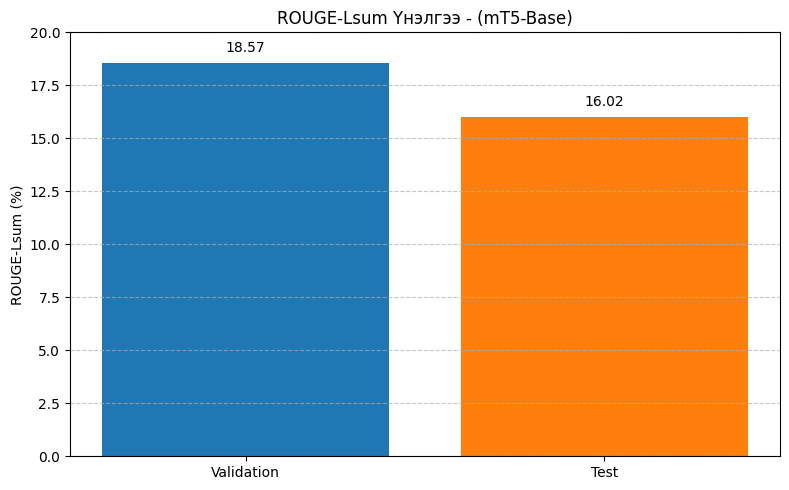

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Retrieve the globally stored best_validation_metrics
# We assume eval_result is from the test set evaluation and is available in the current scope

# Extract RougeLsum for comparison
val_rougeLsum = best_valid_metrics['eval_rougeLsum']
test_rougeLsum = eval_result['eval_rougeLsum']

# Data for plotting
metrics_data = {
    'Metric': ['Validation', 'Test'],
    'Score': [val_rougeLsum, test_rougeLsum]
}
df_comparison = pd.DataFrame(metrics_data)

# Create the bar chart
plt.figure(figsize=(8, 5))
bar_colors = ['#1f77b4', '#ff7f0e'] # Different colors for distinction
plt.bar(df_comparison['Metric'], df_comparison['Score'], color=bar_colors)

plt.ylabel('ROUGE-Lsum (%)')
plt.title('ROUGE-Lsum Үнэлгээ - (mT5-Base)')
plt.ylim(0, 20) # Adjust y-axis limit based on expected ROUGE scores

# Optional: Add the exact value on top of each bar
for index, row in df_comparison.iterrows():
    plt.text(row['Metric'], row['Score'] + 0.5, f"{row['Score']:.2f}", ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()